<img style="float: left;" src="http://sindser.org.br/s/wp-content/uploads/2013/09/iesb1.jpg"  width="300" height="300">

## Instituto de Educação Superior de Brasília
## Pós Graduação em Ciência de Dados
## Softwares para uso em Ciência de Dados I

<h3><font size="3">Leandro Alencar – 1931133007</font></h3>

----
# Brazilian E-Commerce Public Dataset by Olist
## Table of contents
* [Introdução](#introducao)
* [Dados](#data)
* [Análises Descritivas](#analises)
* [Conclusão](#conclusao)


# 1. Introdução <a name="introducao"></a>
No Brasil, milhares de compras são efetuadas pela Internet todos os anos. Trata-se de um mercado em constante ritmo de crescimento, de modo que seria extremamente relevante tentar entender comportamentos do consumidor inerentes a este contexto, como meses em que ocorrem maior quantidade de compras, horário em que são realizados mais negócios, tempo médio de entrega, nível de satisfação, etc.

Para isso, foi selecionado um conjunto de dados disponibilizado pela Olist, a maior loja de departmento dos "marketplaces", com informações de mais de 100 mil pedidos de 2016 a 2018.

Como se tratam de dados reais, estes foram disponibilizados de forma a manter o anonimato de qualquer indivíduo, empresa ou parceiro.

# 2. Dados <a name="data"></a>
A base de dados pode ser acessada no Kaggle, em https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_products_dataset.csv, contendo mais de 100 mil regitros de pedidos em 8 conjuntos de dados separados, sobre:

* Consumidores
* Vendedores
* Produtos
* Pedidos
* Artigos dos pedidos
* Avaliação de pedidos
* Pagamentos
* Geolocalização

Cada conjunto possui informações exclusivas sobre um assunto em questão, podendo ser cruzados de diversas maneiras a fim de se obter informações sobre o quesito escolhido. No caso deste trabalho, a abordagem será realizada com foco nos **Consumidores**.

### Bibliotecas e dependências do Python:
* Pandas – Manipulação e análise de dados 
* NumPy – Manipulação de dados  
* Seaborn - Visualização gráfica    
* Matplotlib – Visualização gráfica     
* Folium – Visualização em mapas 
* Scikit-learn - Aprendizado de máquina

In [7]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import folium
from folium import plugins
from sklearn.cluster import DBSCAN
print('Bibliotecas preparadas!')

Bibliotecas preparadas!


### Importação dos Datasets
Foi realizada a importação de todos os datasets através do Pandas e posteriormente foram cruzados a fim de formar um único Dataframe com informações de: consumidores, geolocalização, pedidos, artigos, produtos, vendedores e avaliações.

In [9]:
files = {'customers'    : '.\olist_customers_dataset.csv',
         'geolocation'  : '.\olist_geolocation_dataset.csv',
         'items'        : '.\olist_order_items_dataset.csv',
         'payment'      : '.\olist_order_payments_dataset.csv',
         'orders'       : '.\olist_orders_dataset.csv',
         'products'     : '.\olist_products_dataset.csv',
         'sellers'      : '.\olist_sellers_dataset.csv',
         'review'       : '.\olist_order_reviews_dataset.csv',
         }

dfs = {}
for key, value in files.items():
    dfs[key] = pd.read_csv(value)

### Cruzamento entre os Datasets e Transformação de Dados
Os cruzamentos foram realizados de forma gradativa, para assegurar que não ocorresse duplicação de dados.

Também tomou-se a decisão de remover dados do ano de 2016 e do mês setembro de 2018, o primeiro por conter apenas 375 registros e o segundo por conter apenas um registro.

In [10]:
# Cruzamento gradativo
customers_location = dfs['customers'].merge(dfs['geolocation'], how='inner', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop_duplicates('customer_id', keep='first')
cusloc_order = customers_location.merge(dfs['orders'], how='inner', on='customer_id')
cuslocord_item = cusloc_order.merge(dfs['items'], how='inner', on='order_id')
cuslocordite_prod = cuslocord_item.merge(dfs['products'], how='inner', on='product_id')
cuslocordite_rev= cuslocordite_prod.merge(dfs['review'], how='left', on='order_id')

# Selecionando as colunas de interesse
final = cuslocordite_rev[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state',
       'geolocation_lat', 'geolocation_lng','order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_photos_qty',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp']]

# Convertendo para datetime
datas = ['order_purchase_timestamp'
        ,'order_purchase_timestamp'
        ,'order_delivered_carrier_date'
        ,'order_delivered_customer_date'
        ,'order_estimated_delivery_date'
        ,'shipping_limit_date'
        ,'review_creation_date'
        ,'review_answer_timestamp' 
        ]

for data in datas:
    final[data] = pd.to_datetime(final[data])

# Criando coluna de tempo de entrega e Hora da compra
final['delivery_time'] = (final['order_delivered_customer_date'].dt.date - final['order_purchase_timestamp'].dt.date).dt.days

# Seleção do período de interesse
final = final[(final['order_purchase_timestamp'].dt.year > 2016) 
              & 
              (final['order_purchase_timestamp'] < pd.to_datetime('20180901'))
             ]
final = final.reset_index(drop=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112639 entries, 0 to 112638
Data columns (total 29 columns):
customer_id                      112639 non-null object
customer_unique_id               112639 non-null object
customer_zip_code_prefix         112639 non-null int64
customer_city                    112639 non-null object
customer_state                   112639 non-null object
geolocation_lat                  112639 non-null float64
geolocation_lng                  112639 non-null float64
order_id                         112639 non-null object
order_status                     112639 non-null object
order_purchase_timestamp         112639 non-null datetime64[ns]
order_approved_at                112624 non-null object
order_delivered_carrier_date     111480 non-null datetime64[ns]
order_delivered_customer_date    110226 non-null datetime64[ns]
order_estimated_delivery_date    112639 non-null datetime64[ns]
order_item_id                    112639 non-null int64
product_id       

# 3. Análises Descritivas <a name="analises"></a>
### 3.1 Volume de compras por mês
A primeira análise realizada foi para verificar a evolução do volume de compras realizadas no decorrer do tempo e se existe alguma sazonalidade.

É possível observar pelo **Gráfico I** que, embora não seja possível identificar sazonalidade, houve aumento expressivo do volume de compras no mês de novembro de 2017 (período em que ocorre o evento "Black Friday") e posteriormente, após uma ligeira queda, o volume se manteve constante e em um nível bastante elevado em relação ao ano anterior. Sinais indicativos de que a Olist, fundada em 2015, está em ritmo de expansão acelerado e consistente.

Gráfico I


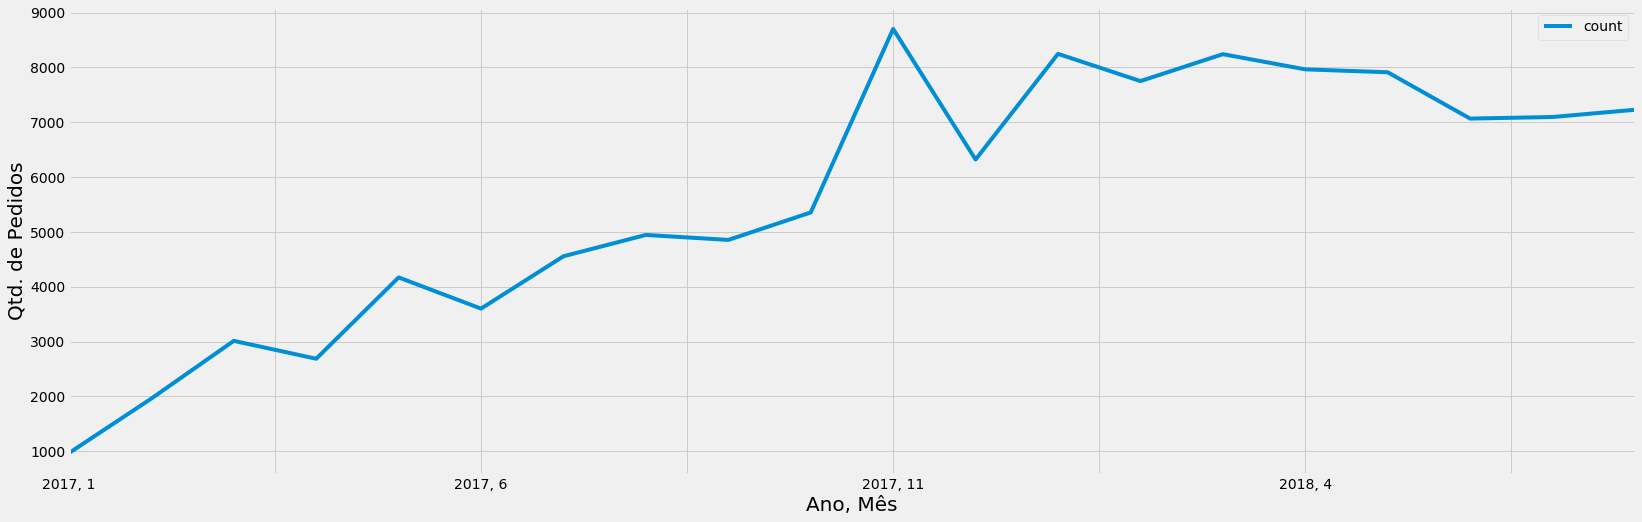

In [11]:
meses_compras = pd.DataFrame()
meses_compras['mes'] = final['order_purchase_timestamp'].dt.month
meses_compras['ano'] = final['order_purchase_timestamp'].dt.year
meses_compras['count'] = final['customer_id']
meses_compras = meses_compras.groupby(['ano','mes'])['count'].count().reset_index()
meses_compras['ano_mes'] = meses_compras['ano'].astype(str) + ', ' + meses_compras['mes'].astype(str)

meses_compras.plot(x='ano_mes', y='count', figsize=(25,8))#, color='#42A5F5', alpha=0.9, ci=None)
plt.xlabel('Ano, Mês', size=20)
plt.ylabel('Qtd. de Pedidos', size=20)

print(r'Gráfico I')
plt.show()

### 3.2 Volume de compras e valor do frete por Estado
A segunda abordagem foi de verificar a movimentação de compras por Estado e também o valor médio gasto em fretes, para visualmente analisar se existe alguma relação entre as variáveis.

A respeito do valor médio pago pelos fretes, a variação é pequena com média de R\\$ 145,18 e desvio padrão de R$ 21,17, conforme **Tabela 1**. Já em relação à observação conjunta do volume de compras e do valor médio pago por estado, é muito interessante observar no **Gráfico II** que o preço médio do frete aparenta ser inversamente proporcional ao volume de compras.

In [12]:
estado_compras = final.groupby('customer_state', as_index=False)['price'].sum().sort_values(by='customer_state')
estado_compras_med = final.groupby('customer_state', as_index=False)['price'].mean().sort_values(by='customer_state')
frete_medio = final.groupby('customer_state', as_index=False)['freight_value'].mean().sort_values(by='customer_state')

print('Tabela 1')
estado_compras_med['price'].describe()

Tabela 1


count    27.00
mean    145.18
std      21.17
min     109.55
25%     124.64
50%     144.98
75%     158.72
max     189.98
Name: price, dtype: float64

Gráfico II


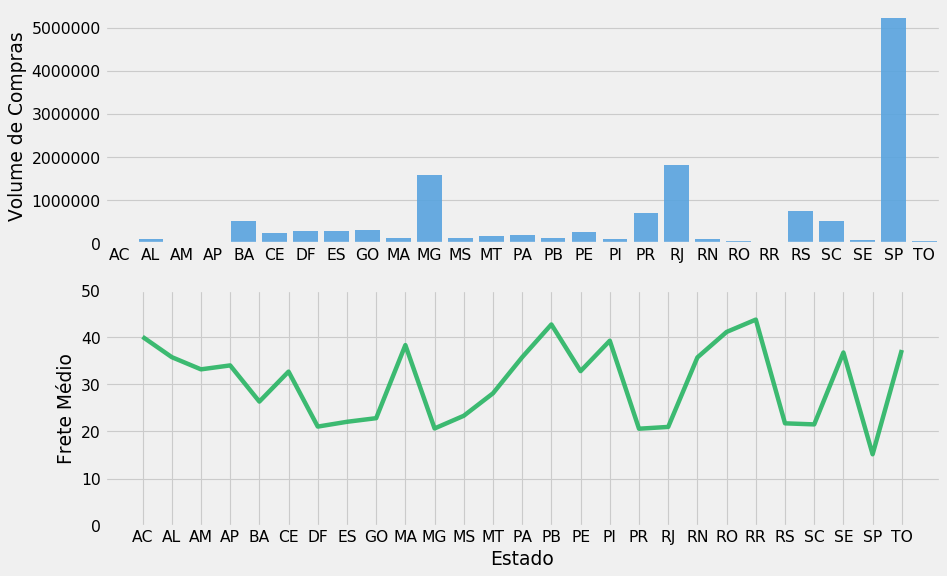

In [13]:
figure(num=None, figsize=(12, 8), dpi=80)

plt.subplot(2, 1, 1)
sns.barplot(x=estado_compras['customer_state'], y=estado_compras['price'], color='#42A5F5', alpha=0.9)
plt.xlabel(None)
plt.ylabel('Volume de Compras')

plt.subplot(2, 1, 2)
sns.lineplot(x=frete_medio['customer_state'], y=frete_medio['freight_value'], color='#28B463', alpha=0.9)
#ylim(top=3)  # adjust the top leaving bottom unchanged
plt.ylim(0,50)
plt.xlabel('Estado')
plt.ylabel('Frete Médio')

print(r'Gráfico II')
plt.show()

### 3.3 Quantidade de Compras por Horário
A fim de verificar as faixas de horário em que mais ocorrem compras, optou-se por criar uma coluna com apenas a hora, sem os minutos, para que fosse possível visualizar os dados em um histograma, conforme demonstrado no **Gráfico III**.

É possível constatar que o período de maior movimentação de compras é compreendido entre 10:00 e 22:00, representando, então, 50% das tempo de um dia completo.

Gráfico III


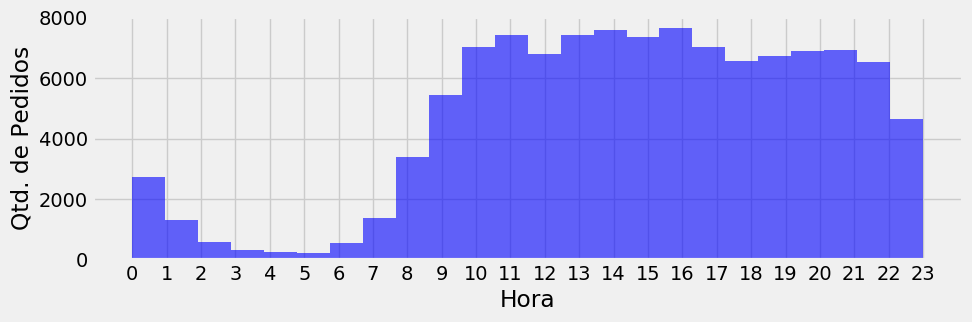

In [14]:
# Criação da coluna com o valor referente às Horas
final['purchase_hour'] = final['order_purchase_timestamp'].dt.hour

figure(num=None, figsize=(10, 3), dpi=100)
plt.hist(final['purchase_hour'], bins=24, facecolor='b', alpha=0.6)
plt.xticks(ticks=np.arange(24))
plt.xlabel('Hora')
plt.ylabel('Qtd. de Pedidos')

print(r'Gráfico III')
plt.show()

### 3.4 Valor e quantidade de items por consumidor
Uma tabela foi criada para reunir dados referentes ao consumidor para, a partir deles, verificar alguma informação que fosse interessante. Neste caso, definiu-se que iria análises seriam realizadas com foco no somatório de todas as compras realizadas.

Dentro do "Top 10" observado, um único consumidor realizou compras no valor total de R\\$ 13440.00, enquanto a média foi de R$ 143.00, com apenas 8 produtos comprados e um nota de avaliação média de apenas 1.00. Fato que chamou atenção, então foram selecionados mais 2 consumidores com nota igual a 1.00 para se verificar os comentários realizados na avaliação a fim de avaliar semelhanças. Nesta pequena seleção para observação, foi possível perceber que os 3 consumidores atribuíram a nota mínima devido a problemas com a entrega do produto comprado.

Seria muito interessante a utilização de Processamento de Linguagem Natural para uma futura abordagem dentro deste escopo.

In [15]:
#Seleção de informações agrupadas pelo consumidor
cus_valor = final.groupby('customer_unique_id', as_index=False)['price'].sum() #price_x
cus_qtd = final.groupby('customer_unique_id', as_index=False)['price'].count() #price_y
cus_frete = final.groupby('customer_unique_id', as_index=False)['freight_value'].sum()
cus_loc = final[['customer_unique_id', 'geolocation_lat', 'geolocation_lng', 'customer_state']].drop_duplicates('customer_unique_id')
cus_review = final.groupby('customer_unique_id', as_index=False)['review_score'].mean()

#União das informações em um Dataframe
customer = cus_valor.merge(cus_qtd, on='customer_unique_id')
customer = customer.merge(cus_frete, on='customer_unique_id')
customer = customer.merge(cus_loc, on='customer_unique_id')
customer = customer.merge(cus_review, on='customer_unique_id')
customer = customer.rename(columns={'price_x':'price', 'price_y':'count_items'})

print('Média do valor de compra: R$ ' + str(round(customer['price'].mean(),2)) + '\nDesvio Padrão: R$ ' + str(round(customer['price'].std(),2)))
customer.sort_values(by='price', ascending=False).head(10)

Média do valor de compra: R$ 143.0
Desvio Padrão: R$ 218.97


,customer_unique_id,price,count_items,freight_value,geolocation_lat,geolocation_lng,customer_state,review_score
3772,0a0a92112bd4c708ca5fde585afaa872,13440.00,8,224.08,-22.90,-43.18,RJ,1.00
80906,da122df9eeddfedc1dc1f5349a1a690c,7388.00,2,183.63,-22.87,-42.27,RJ,5.00
43891,763c8b1c9c68a0229c42c9fc6f662b93,7160.00,4,114.88,-20.38,-40.31,ES,1.00
81746,dc4802a71eae9be1dd28f5d788ceb526,6735.00,1,194.31,-20.50,-54.57,MS,5.00
25865,459bef486812aa25204be022145caa62,6729.00,1,193.21,-20.27,-40.28,ES,1.00
94572,ff4159b92c40ebe40454e3e6a7c35ed6,6499.00,1,227.66,-22.21,-49.95,SP,5.00
23805,4007669dec559734d6f53e029e360987,5934.60,6,146.94,-20.16,-44.88,MG,1.00
88532,eebb5dda148d3893cdaf5b5ca3040ccb,4690.00,1,74.34,-23.68,-46.42,SP,4.00
34622,5d0a2980b292d049061542014e8960bf,4599.90,2,209.54,-16.69,-49.28,GO,1.00
27084,48e1ac109decbb87765a3eade6854098,4590.00,1,91.78,-7.10,-34.84,PB,5.00


In [16]:
a = final[['customer_unique_id','review_score', 'review_comment_message']][
    (final['customer_unique_id'] == '0a0a92112bd4c708ca5fde585afaa872')
    |(final['customer_unique_id'] == '763c8b1c9c68a0229c42c9fc6f662b93')
    |(final['customer_unique_id'] == '459bef486812aa25204be022145caa62')]
print('Comentários por parte dos consumidores que pontuarão a avaliação com nota 1.00')
print('')
print('CONSUMIDOR 1: ' + a.groupby('customer_unique_id')['review_comment_message'].min()[0])
print('CONSUMIDOR 2: ' + a.groupby('customer_unique_id')['review_comment_message'].min()[1])
print('CONSUMIDOR 3: ' + a.groupby('customer_unique_id')['review_comment_message'].min()[2])

Comentários por parte dos consumidores que pontuarão a avaliação com nota 1.00

CONSUMIDOR 1: Peço por favor verificar a entrega do pedido, pois não recebemos.
CONSUMIDOR 2: Demora no retorno sobre o endereço de entrega
CONSUMIDOR 3: Comprei 04 unidades, e foram entregues apenas 02 pacotes com 01 unidade cada. Ainda não sei se serão entregues as outras 02 unidades faltantes.
De qualquer forma, a entrega deve ser de uma única vez.


### 3.5 Clusterização
Por fim, foi realizada um análise de cluster utilizando as distâncias entre os consumidores, com base nas informações de latitude e longitude. Para essa tarefa, o algoritimo DBSCAN foi escolhido: consiste em um método que determina um cluster com base em uma quantidade mínima de pontos dentro de um raio especificado para cada ponto.

Foi selecionada uma amostra aleatória de 1000 consumidores devido à limitações da biblioteca folium em relação ao número máximo de pontos possíveis de serem desenhados no gráfico.

Como resultado, foi possível identificar, claramente, as regiões de Águas Claras, Guará, Cruzeiro, Asa Sul, Asa Norte e as demais cidades satélites como pertencentes a um mesmo cluster. Com isso também foi possível encontrar o valor médio de compras realizadas para cada um desses clusters, sendo a maior delas a região do Guará.


In [17]:
# Selecionando dados do Distrito Federal e uma amostra de 1000 consumidores
customer_df = customer[customer['customer_state'] == 'DF']
customer_df = customer_df.sample(1000, random_state=1223)

Clus_dataSet = customer_df[['geolocation_lat','geolocation_lng']]

db = DBSCAN(eps=0.015, min_samples=50).fit(Clus_dataSet)
labels = db.labels_
customer_df["Clus_Db"]=labels

# A sample of clusters
print('Clusters formados:')
customer_df["Clus_Db"].value_counts()

Clusters formados:


-1    582
 0    127
 1    107
 2     68
 3     63
 4     53
Name: Clus_Db, dtype: int64

In [18]:
# Visualização gráfica
map_clusters = folium.Map(location=[-15.89, -47.9], zoom_start=11)
rainbow = ['#CD5C5C','#7B68EE','#FF8C00','#8B4513','#008B8B','#FF69B4']
print(' Cluster -1: Ciano\n','Cluster  0: Rosa\n','Cluster  1: Vermelho\n','Cluster  2: Azul\n','Cluster  3: Laranja\n','Cluster  4: Marrom')
# add markers to the map
markers_colors = []
for lat, lon, price, cluster in zip(customer_df['geolocation_lat'], customer_df['geolocation_lng'], customer_df['price'], customer_df['Clus_Db']):
    label = folium.Popup('R$ ' + str(price) + ' \(Cluster ' + str(cluster) + '\)', parse_html=True, max_width=150,min_width=100)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters 

 Cluster -1: Ciano
 Cluster  0: Rosa
 Cluster  1: Vermelho
 Cluster  2: Azul
 Cluster  3: Laranja
 Cluster  4: Marrom


In [19]:
# Agrupamento por Região encontrada na clusterização
customer_df['Região'] = customer_df['Clus_Db'].replace({-1:'Outras Satélites'
                                                       ,0:'Águas Claras'
                                                       ,1:'Asa Norte'
                                                       ,2:'Asa Sul'
                                                       ,3:'Guará'
                                                       ,4:'Cruzeiro'
                                                       })

print('Valor médio de compras:')
customer_df.groupby('Região')['price'].mean().sort_values(ascending=False)

Valor médio de compras:


Região
Guará              191.56
Cruzeiro           163.03
Asa Sul            160.62
Águas Claras       160.36
Outras Satélites   138.92
Asa Norte          124.26
Name: price, dtype: float64

# 4. Conclusão <a name="conclusao"></a>
Embora a quantidade de registros possa ser considerada pequena, tendo em vista que tratam-se de compras na internet durante um período de 2 anos, os dados são muito interessante para realizar análises a fim de identificar comportamentos ou tentar entender o que possa impactar na satisfação dos consumidores.

Não há indícios suficientes para afirmar que existe sazonalidade no consumo, mas que a partir do período mais atual do conjunto de dados o comportamento é de consumo elevado e constante. Também constatou-se que os estados que mais movimentam este mercado são os que possuem menor custo médio em relação ao valor do frete, e que o período de maior movimentação corresponde à metade de um dia inteiro, ficando compreendido entre 10:00 e 22:00. 

Além disso, foi identificado que embora existam consumidores realizaram gastos muito acima da média, alguns deles não tiveram uma boa experiência com o serviço de entrega e isso contribuiu para um baixíssimo nível satisfação. Existe ainda espaço disponível para uma análise mais aprofundada para identificar quais fatores possam estar relacionados à satisfação do consumidor utilizando Processamento de Linguagem Natural (Natural Language Processing, ou NLP, em inglês).